# Solve the Schrödinger equation for tensor charmonium

## Initialize

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.integrate import solve_ivp

## Fit tensor 4-point correlator

### Set parameters

In [2]:
n = 32
arrayLength = int(n**3)
rmin = 3
rmax = 14
dataPath = "result/c4pt/prev/prev.ps.29.bin.txt"

### Fit (main part)

In [3]:
# Define Cornell potential
def cornell_fit(r, A, sigma, V0):
    return -A / r + sigma * r + V0


fitPara = {
    "A": 1,
    "sigma": 0.1,
    "V0": 0.01,
}

rawData = np.loadtxt(dataPath, dtype=np.float64)[0:arrayLength]

# Sort data by distance (from shorter to longer)
mask = (rawData[:, 0] > rmin) & (rawData[:, 0] < rmax)
subData = rawData[mask]
sortedIndices = np.argsort(subData[:, 0])
fitData = subData[sortedIndices]

# Fit
least_squares = LeastSquares(fitData[:, 0], fitData[:, 1], fitData[:, 2], cornell_fit)  # type: ignore
m = Minuit(least_squares, **fitPara)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.052e+04 (χ²/ndof = 32.1) │              Nfcn = 70               │
│ EDM = 1.13e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │  0.6575   │  0.0031   │            │            │         │         │       │
│ 1 │ sigma │ 27.75e-3  │  0.14e-3  │            │            │         │         │       │
│ 2 │ V0    │  0.0080   │  0.0014   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         A     sigma        V0 │
├───────┼───────────────────────────────┤
│     A │  9.84e-06 -0.417e-6    4.2e-6 │
│ sigma │ -0.417e-6  1.97e-08 -0.186e-6 │
│    V0 │    4.2e-6 -0.186e-6  1.82e-06 │
└───────┴───────────────────────────────┘

## Solve the Schrödinger equation

### Set parameters

In [4]:
r0 = 0.001
rmax = 32
y0 = [r0 * 2, r0**2]

A = np.float64(m.values["A"])
sigma = np.float64(m.values["sigma"])
V0 = np.float64(m.values["V0"])

### Solve (main part)

Charm quark mass: 1871.2774402918783 MeV


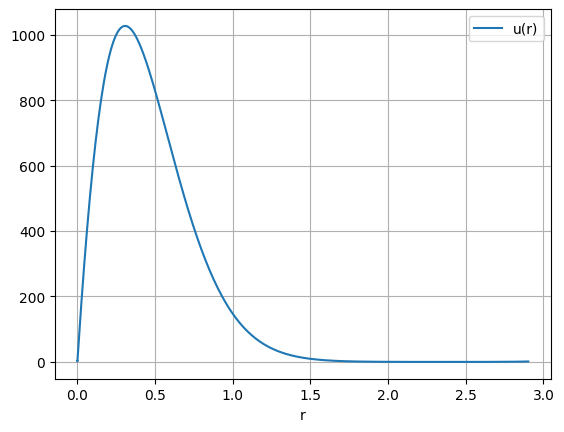

In [5]:
E = 0.20336045  # T channel (3, 12)
print("Charm quark mass: {} MeV".format(E / 0.2364 * 2.1753 * 1000))


def cornell(r, y, E, A, sigma, V0):
    u, uprime = y
    dydt = [
        uprime,
        # (- A / r + sigma * r + V0) * u,  # PS channel
        (-E - A / r + sigma * r + V0 + 2 / r**2) * u,  # T channel
    ]
    return dydt


sol = solve_ivp(cornell, [r0, rmax], y0, args=(E, A, sigma, V0), max_step=0.1)

plt.plot(sol.t * 0.090713, sol.y[0] / sol.t, label="u(r)")
plt.legend(loc="best")
plt.xlabel("r")
plt.grid()
plt.show()

wfData = np.vstack((sol.t, sol.y[0]))
np.savetxt("result/c4pt/wavefunction.T.txt", wfData)